
# Comparison between different LLMs

In [ ]:
import pandas as pd
from tqdm import tqdm
from baseline.train import train_baseline_model
from baseline.eval import cal_group_kl_divergence
import os

def get_mobility_agent_result(sample_list,result_folder= "results/cambridge",model_name="mobility_agent"):
    eval_list = []
    for num_samples in sample_list:
        result_file = os.path.join(result_folder,f"mobility_agent_{num_samples}.csv")
        result_df = pd.read_csv(result_file)
        primary_mode_list = ['walking', 'biking', 'auto_passenger', 'public_transit','private_auto', 'on_demand_auto','other_travel_mode']
        duration_minutes_list = ['0-10','10-20', '20-30', '30-40', '40-50', '50-60']
        # Filter the dataframe with valid output
        result_df = result_df[result_df['predicted_mode'].isin(primary_mode_list)]
        result_df = result_df[result_df['predicted_duration'].isin(duration_minutes_list)]
        kl_df, overall_kl, overall_mae = cal_group_kl_divergence(result_df=result_df)
        eval_list.append({
            "model": model_name,
            "num_samples": num_samples,
            "overall_kl": overall_kl,
            "overall_mae": overall_mae
        })
    return eval_list

# Initialize the list with mobility agent results
all_samples = [i*10 for i in range(11)] + [i*100 for i in range(2,11)]

qwen_results = get_mobility_agent_result(all_samples,result_folder= "results/cambridge",model_name="Qwen3")
gemma_results = get_mobility_agent_result(all_samples,result_folder= "results/llms/gemma3",model_name="Gemma3")
llama_results = get_mobility_agent_result(all_samples,result_folder= "results/llms/llama3.1",model_name="Llama3.1")


# Add non-None results to the list
result_list = qwen_results + gemma_results+llama_results
# # Convert to DataFrame and save
result_df = pd.DataFrame(result_list)
result_df.to_csv("results/llm_scores.csv", index=False)
# print(f"Results saved to results/llm_scores.csv")
result_df.head()

,model,num_samples,overall_kl,overall_mae
0,Qwen3,0,1.249948,0.185377
1,Qwen3,10,0.709912,0.123127
2,Qwen3,20,0.670283,0.106373
3,Qwen3,30,0.569380,0.092031
4,Qwen3,40,0.596527,0.107043


/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_53913/453061684.py:124: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle=':', alpha=0.7)


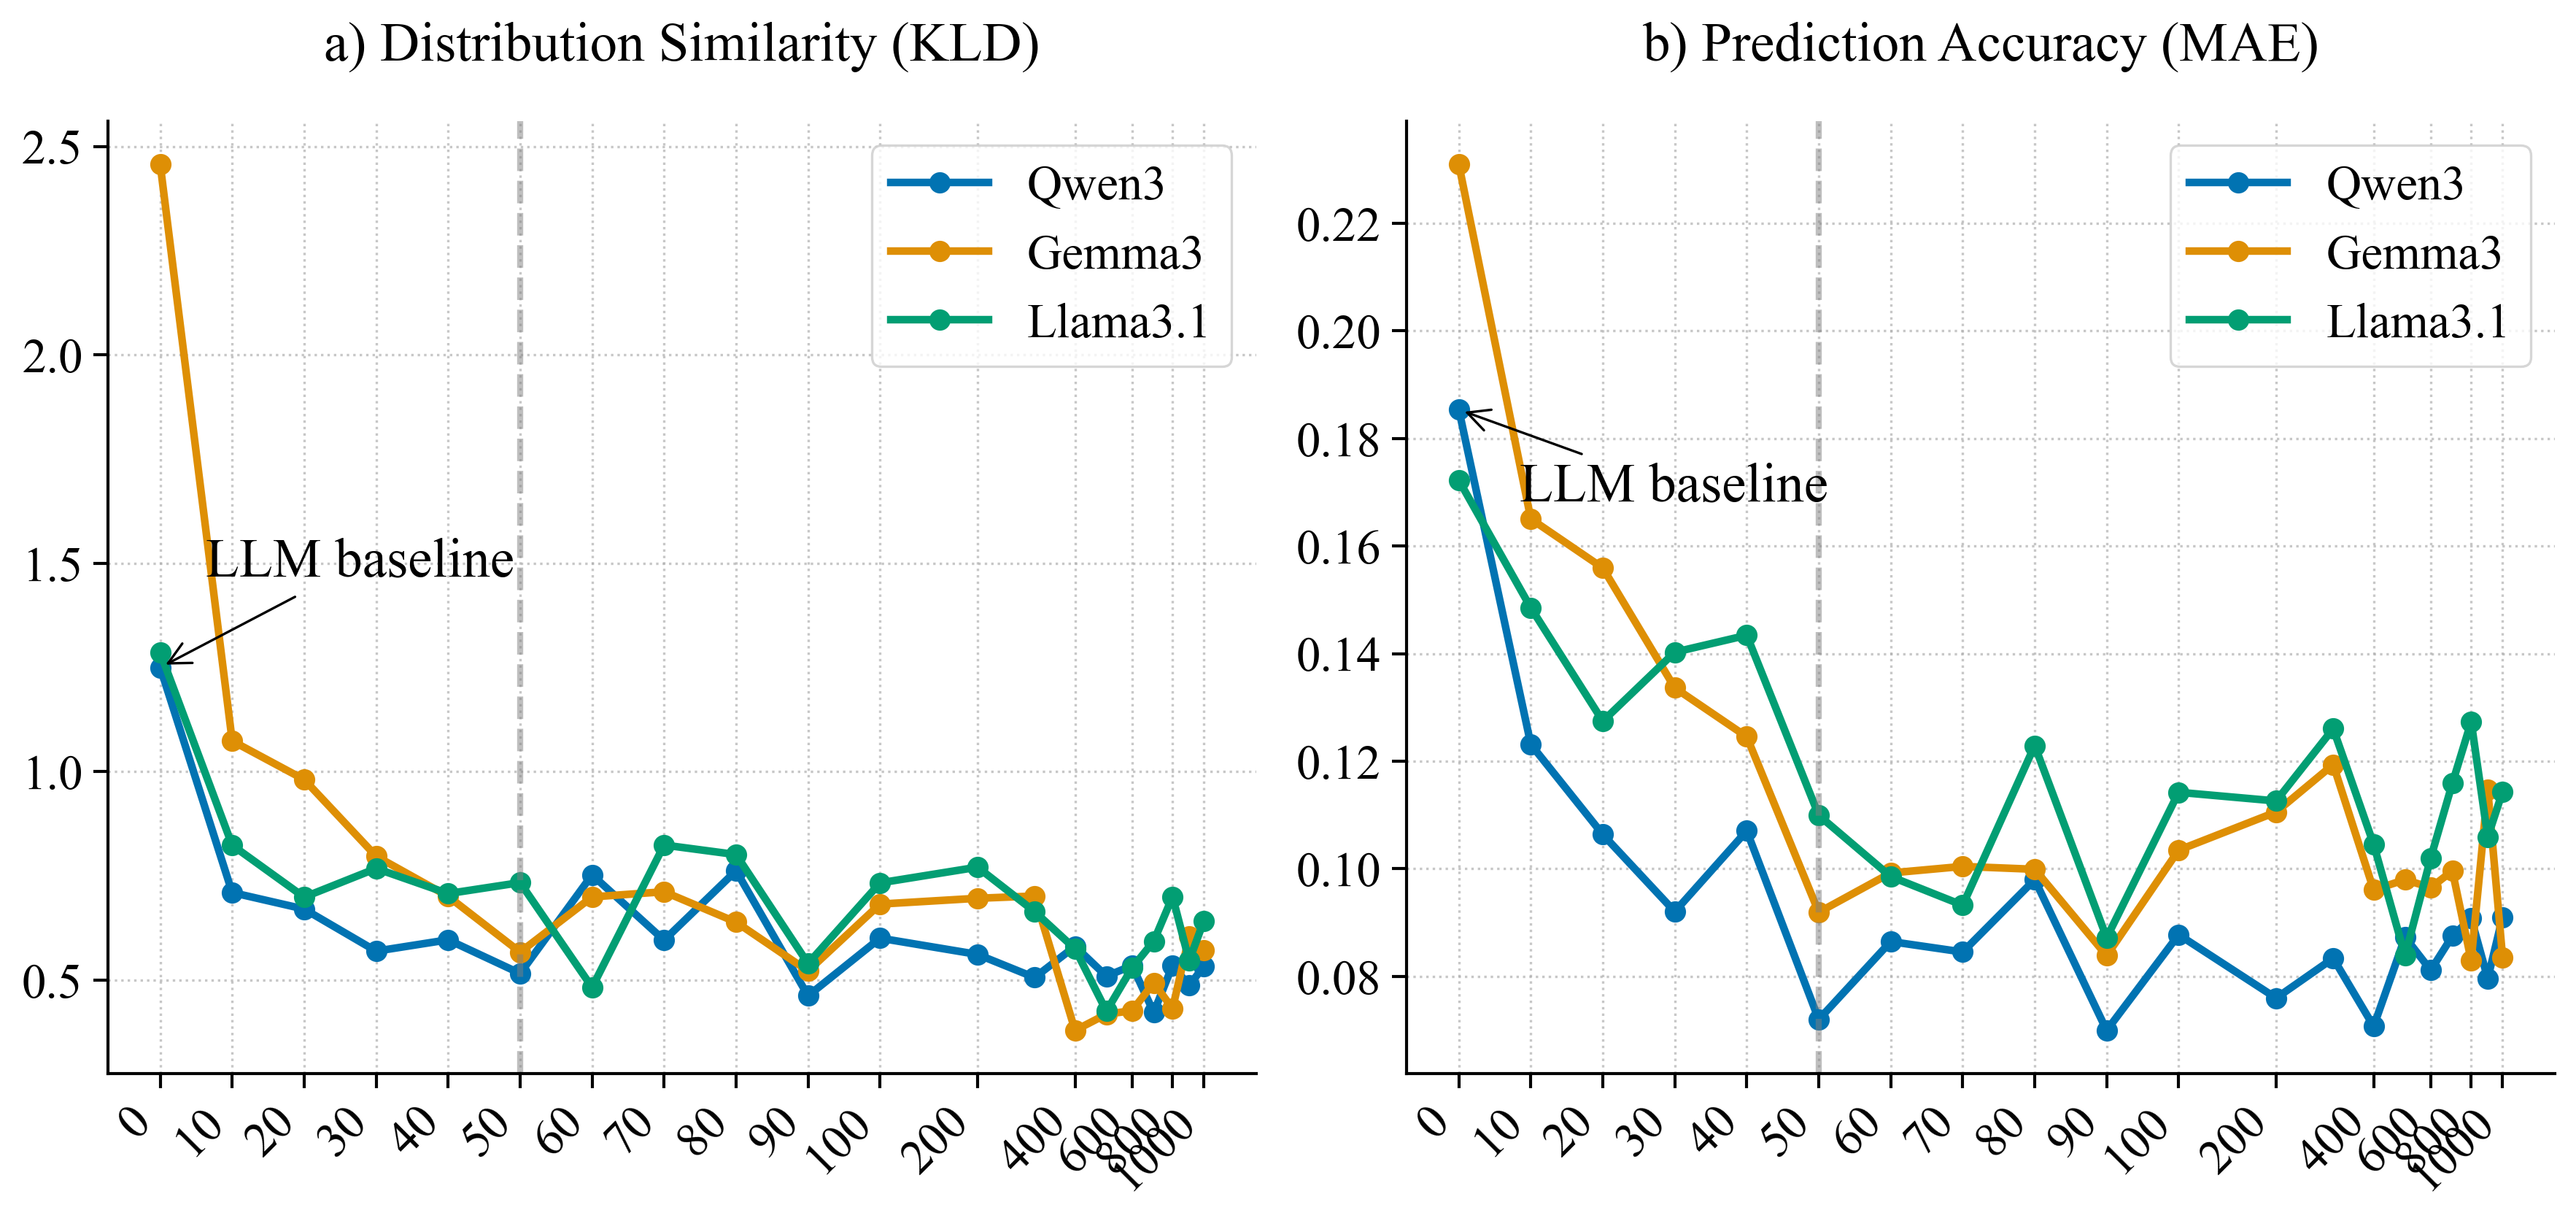

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 15,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})

plot_df =pd.read_csv("results/llm_scores.csv")
# Set the style for the plots
# plt.style.use('white')
# sns.set_context("notebook", font_scale=1.2)
sns.set_context("paper", font_scale=1.6) 

fontsize = 16
line_kws = {'linewidth': 2.5, 'marker': 'o', 'markersize': 6}

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6),dpi=300)

# Get unique models and create a color palette
models = plot_df['model'].unique()
palette = sns.color_palette("colorblind", len(models))
model_color = dict(zip(models, palette))

# Get the x values we want to plot
sample_values = sorted(plot_df['num_samples'].unique())
tick_samples = [i*10 for i in range(11)] + [i*200 for i in range(1,6)]

# Plot KL divergence in the first subplot
ax = axes[0]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_kl'], 
            label=f"{model}",color=model_color[model],**line_kws)

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Add annotation for LLM without reference data at x=0
zero_data = plot_df[plot_df['num_samples'] == 0]
if not zero_data.empty:
    # Find the y-value at x=0 for annotation
    y_value = zero_data['overall_kl'].values[0]
    # Add annotation with an arrow
    ax.annotate('LLM baseline', 
                xy=(0, y_value), 
                xytext=(15, 30),  # Offset text position
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->'), 
                fontsize=fontsize+2)
    
ax.set_xlabel('', fontsize=fontsize, labelpad=10)
ax.set_ylabel('', fontsize=fontsize, labelpad=10)
ax.set_title('a) Distribution Similarity (KLD)', fontsize=fontsize+2, pad=20)

ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)

# Plot MAE in the second subplot
# Plot MAE in the second subplot
ax = axes[1]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_mae'], 
            label=f"{model}",color=model_color[model],**line_kws)

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Add annotation for LLM without reference data at x=0
zero_data = plot_df[plot_df['num_samples'] == 0]
if not zero_data.empty:
    # Find the y-value at x=0 for annotation
    y_value = zero_data['overall_mae'].values[0]
    # Add annotation with an arrow
    ax.annotate('LLM baseline', 
                xy=(0, y_value), 
                xytext=(20, -30),  # Offset text position
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->'), 
                fontsize=fontsize+2)

ax.set_xlabel('', fontsize=fontsize, labelpad=10)
ax.set_ylabel('', fontsize=fontsize, labelpad=10)
ax.set_title('b) Prediction Accuracy (MAE)', fontsize=fontsize+2, pad=20)
ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and add title
plt.tight_layout()
# plt.suptitle('Model Performance Across Different Sample Sizes (Lower is Better)', 
#             fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)

# Final adjustments
for ax in axes:
    ax.grid(False, linestyle=':', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Show the plot
plt.show()

# Factor Analysis

In [27]:
import pandas as pd
result_file = "results/cambridge/mobility_agent_50.csv"
result_df = pd.read_csv(result_file)

In [28]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Dict, Union, Optional
import os
import json


# Load environment variables from .env file
load_dotenv()
BASE_URL = os.getenv('BASE_URL', 'http://localhost:11434/v1')
API_KEY = os.getenv('API_KEY', '123')
MODEL = os.getenv('MODEL', 'qwen3')


client = OpenAI(base_url=BASE_URL,api_key=API_KEY)

input_factors = ['age_group', 'income_group', 'employment_status', 'household_size','available_vehicles', 'education_level', 'desire', 'start_time']

class ReasonFactors(BaseModel):
    factors: List[str] = Field(description="The categorized factors")


def analyze_reasons(selection_reason):
    # Create a completion
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content":
            '''You are an NLP researcher tasked with categorizing transportation mode choice reasons into the factors provided below.
            Note:
            - desire means the current desire of this person, for example, go home/work/eat/shop/school etc.
            Rules:
            - Do not invent new factors.
            - Do not reply with repeated factors.
            '''},
            {"role": "user", "content": f'''
            Here are the reasons for transportation mode choices: {selection_reason}
            Categorize the reasons strictly into these factors: {input_factors}.
            '''}
        ],
        response_format=ReasonFactors,
    )
    # Parse the response
    factors = response.choices[0].message.content
    return json.loads(factors)

In [29]:
from tqdm import tqdm

analyzed_factors = []
for idx,row in tqdm(result_df.iterrows(),total=len(result_df)):
    try:
        selection_reason = row['selection_reason']
        response = analyze_reasons(selection_reason)
        factors = set(response['factors'])
        analyzed_factors.append(json.dumps(list(factors)))
    except Exception as e:
        print(e)

result_df['factors'] = analyzed_factors
result_df.to_csv('results/factor_analysis.csv')

100%|██████████| 1000/1000 [1:00:04<00:00,  3.60s/it] 


In [7]:
import pandas as pd
result_file = 'results/factor_analysis.csv'
result_df = pd.read_csv(result_file )
result_df.head()

,Unnamed: 0.1,Unnamed: 0,person_id,age,gender,employment_status,household_size,household_income,available_vehicles,industry,...,start_time,primary_mode,duration_minutes,age_group,income_group,predicted_mode,predicted_duration,selection_reason,choice_weights,factors
0,0,0,14941376504966255761,16,male,not_in_labor_force,4,140343,two,not_working,...,14,walking,10-20,Under 18,$100k-$150k,walking,0-10,"[""As a young person with two vehicles availabl...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[""available_vehicles"", ""start_time"", ""employme..."
1,1,1,741506727884677094,60,male,employed,1,37850,one,naics445110,...,14,walking,50-60,55-64,$10k-$50k,private_auto,10-20,"[""As a 55-64 year old employed individual with...","[{""primary_mode"": ""walking"", ""duration_minutes...","[""household_size"", ""age_group"", ""available_veh..."
2,2,2,5066275312758875498,17,male,employed,4,776722,three_plus,naics31_33,...,12,biking,0-10,Under 18,$300k+,walking,20-30,"[""As a young, employed individual with a high ...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[""household_size"", ""employment_status"", ""avail..."
3,3,3,11838005633882312749,69,female,employed,2,92736,two,naics621492,...,22,auto_passenger,10-20,65+,$50k-$100k,private_auto,10-20,"[""As someone in the 65+ age group with an adva...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[""employment_status"", ""age_group"", ""available_..."
4,4,4,813905790027797463,20,male,not_in_labor_force,1,0,unknown_num_vehicles,not_working,...,19,walking,10-20,18-24,Under $10k,walking,10-20,"[""As a young adult with limited income and not...","[{""primary_mode"": ""walking"", ""duration_minutes...","[""available_vehicles"", ""income_group"", ""desire""]"


In [34]:
from collections import Counter
import json

input_factors = ['age_group', 'income_group', 'employment_status', 'household_size','available_vehicles', 'education_level', 'desire', 'start_time']

result_df.head()

analyzed_factors = []
factors = [json.loads(x) for x in result_df['factors'].to_list()]
for f in factors:
    analyzed_factors.extend(f)

factor_counter = Counter(analyzed_factors)
factor_counter = {k:v for k,v in factor_counter.items() if k in input_factors}
factor_counter

{'available_vehicles': 972,
 'start_time': 451,
 'employment_status': 600,
 'desire': 997,
 'household_size': 599,
 'age_group': 724,
 'education_level': 732,
 'income_group': 612}

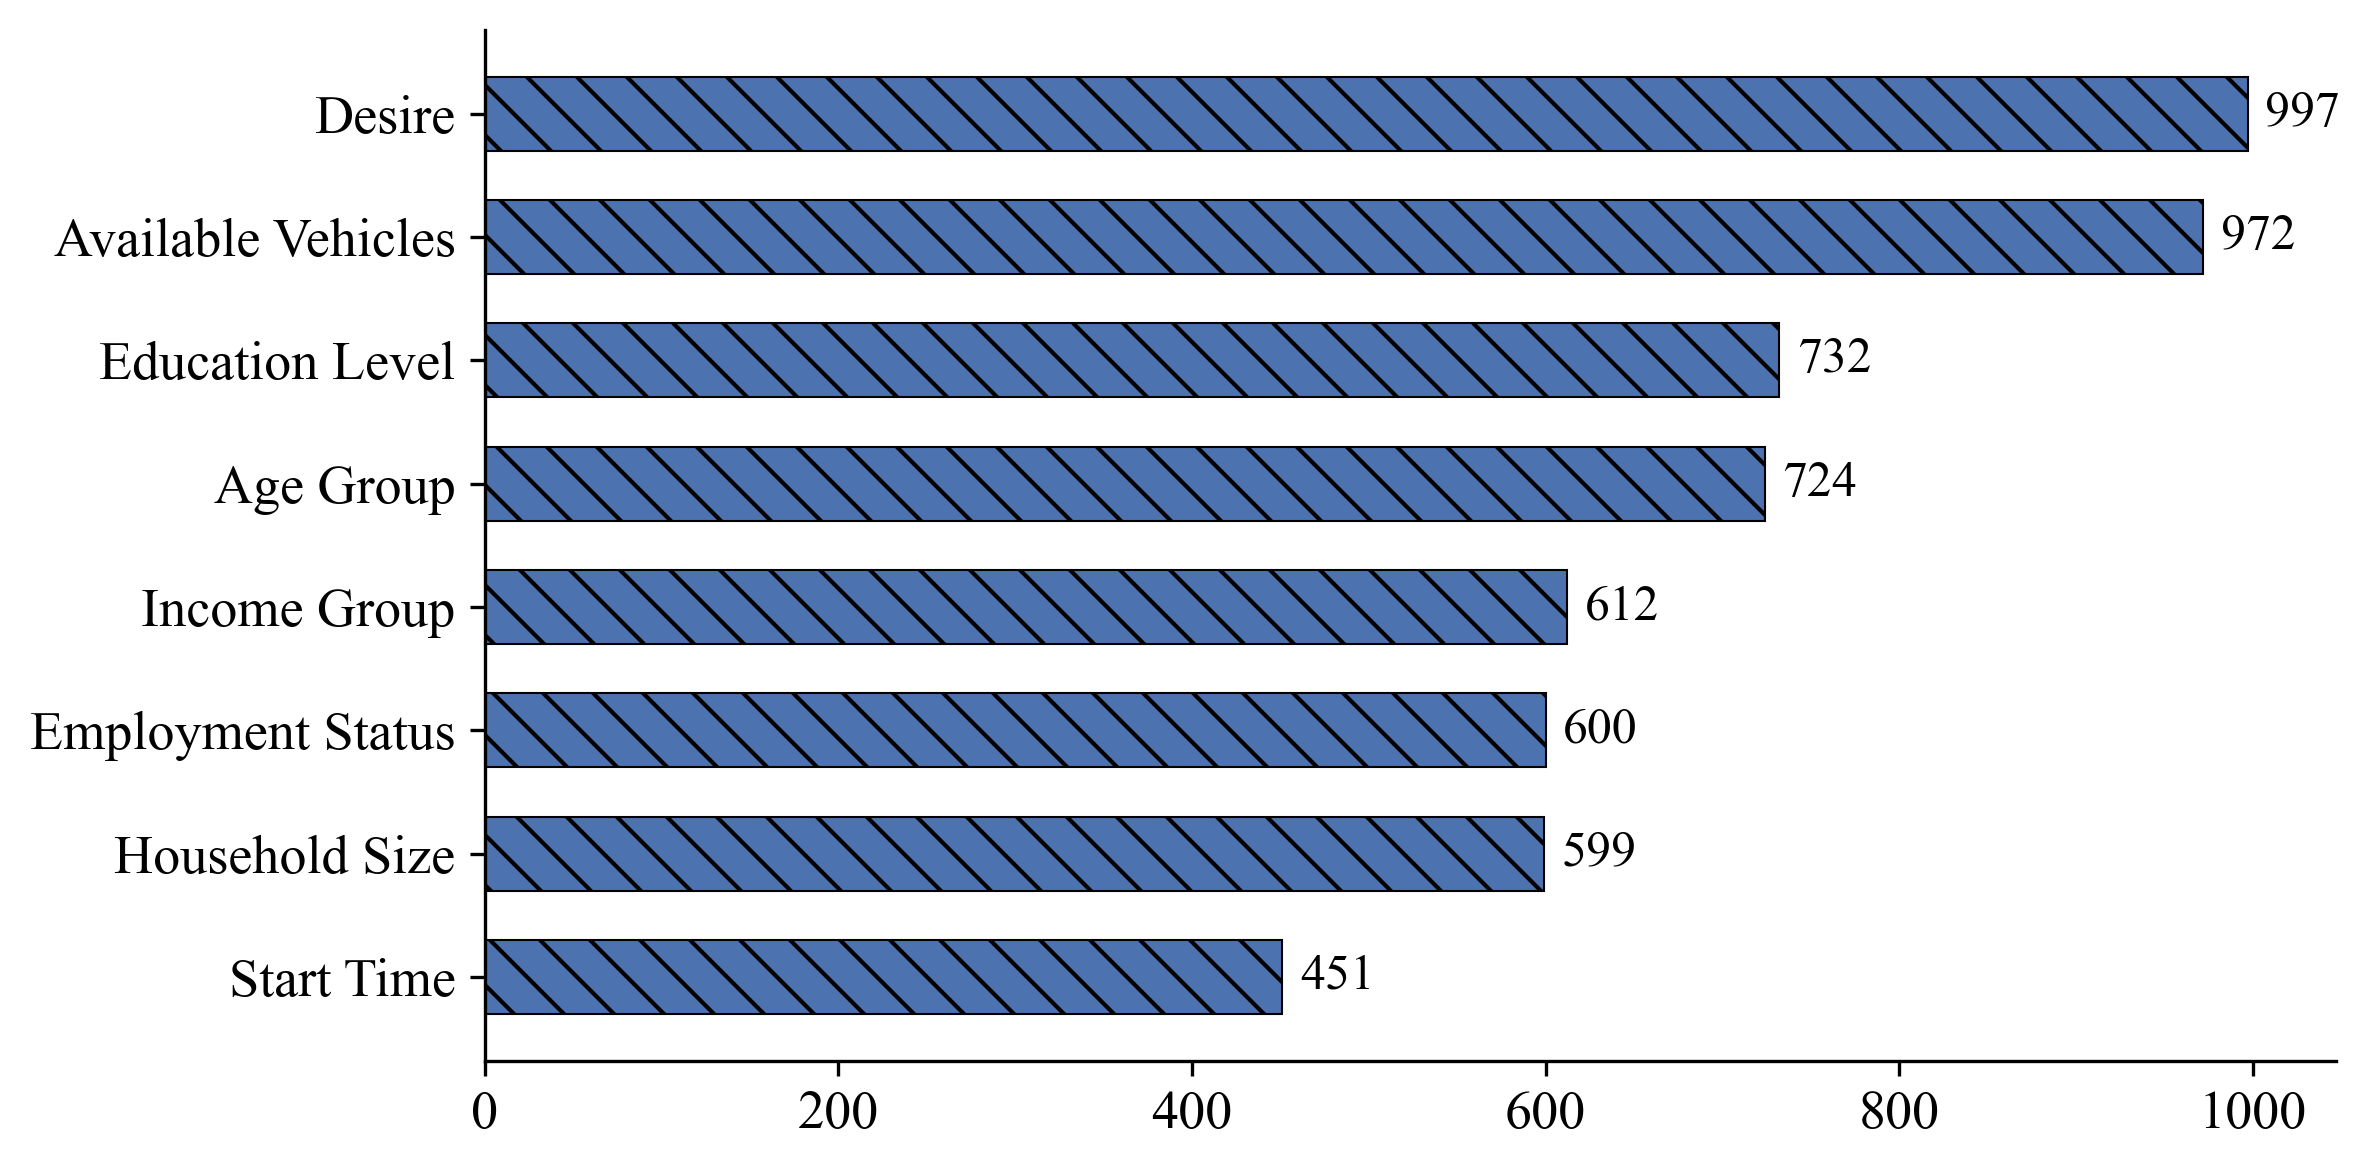

In [87]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 15,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})


# Sort factors by importance
sorted_factors = sorted(factor_counter.items(), key=lambda x: x[1], reverse=True)
factor_names = [x[0].replace('_', ' ').title() for x in sorted_factors]
importance_values = [x[1] for x in sorted_factors]

# Create plot
#4C72B0
plt.figure(figsize=(8, 4))
bars = plt.barh(factor_names, importance_values, color='#4C72B0',height=0.6,edgecolor='black',linewidth=0.5,hatch='\\\\',)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}', 
             va='center', ha='left', fontsize=12)

# Styling
plt.xlabel('')
plt.ylabel('')
# plt.title('Relative Importance of Factors in Transportation Choice Model', 
#           fontsize=14, pad=20)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

# Remove spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.show()

# Factor Analysis across different age groups

In [57]:
import pandas as pd
from collections import Counter
import json

result_file = 'results/factor_analysis.csv'
result_df = pd.read_csv(result_file)
result_df['factors'] = result_df['factors'].apply(lambda x: json.loads(x))
result_df.head()

,Unnamed: 0.1,Unnamed: 0,person_id,age,gender,employment_status,household_size,household_income,available_vehicles,industry,...,start_time,primary_mode,duration_minutes,age_group,income_group,predicted_mode,predicted_duration,selection_reason,choice_weights,factors
0,0,0,14941376504966255761,16,male,not_in_labor_force,4,140343,two,not_working,...,14,walking,10-20,Under 18,$100k-$150k,walking,0-10,"[""As a young person with two vehicles availabl...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[available_vehicles, start_time, employment_st..."
1,1,1,741506727884677094,60,male,employed,1,37850,one,naics445110,...,14,walking,50-60,55-64,$10k-$50k,private_auto,10-20,"[""As a 55-64 year old employed individual with...","[{""primary_mode"": ""walking"", ""duration_minutes...","[household_size, age_group, available_vehicles..."
2,2,2,5066275312758875498,17,male,employed,4,776722,three_plus,naics31_33,...,12,biking,0-10,Under 18,$300k+,walking,20-30,"[""As a young, employed individual with a high ...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[household_size, employment_status, available_..."
3,3,3,11838005633882312749,69,female,employed,2,92736,two,naics621492,...,22,auto_passenger,10-20,65+,$50k-$100k,private_auto,10-20,"[""As someone in the 65+ age group with an adva...","[{""primary_mode"": ""private_auto"", ""duration_mi...","[employment_status, age_group, available_vehic..."
4,4,4,813905790027797463,20,male,not_in_labor_force,1,0,unknown_num_vehicles,not_working,...,19,walking,10-20,18-24,Under $10k,walking,10-20,"[""As a young adult with limited income and not...","[{""primary_mode"": ""walking"", ""duration_minutes...","[available_vehicles, income_group, desire]"


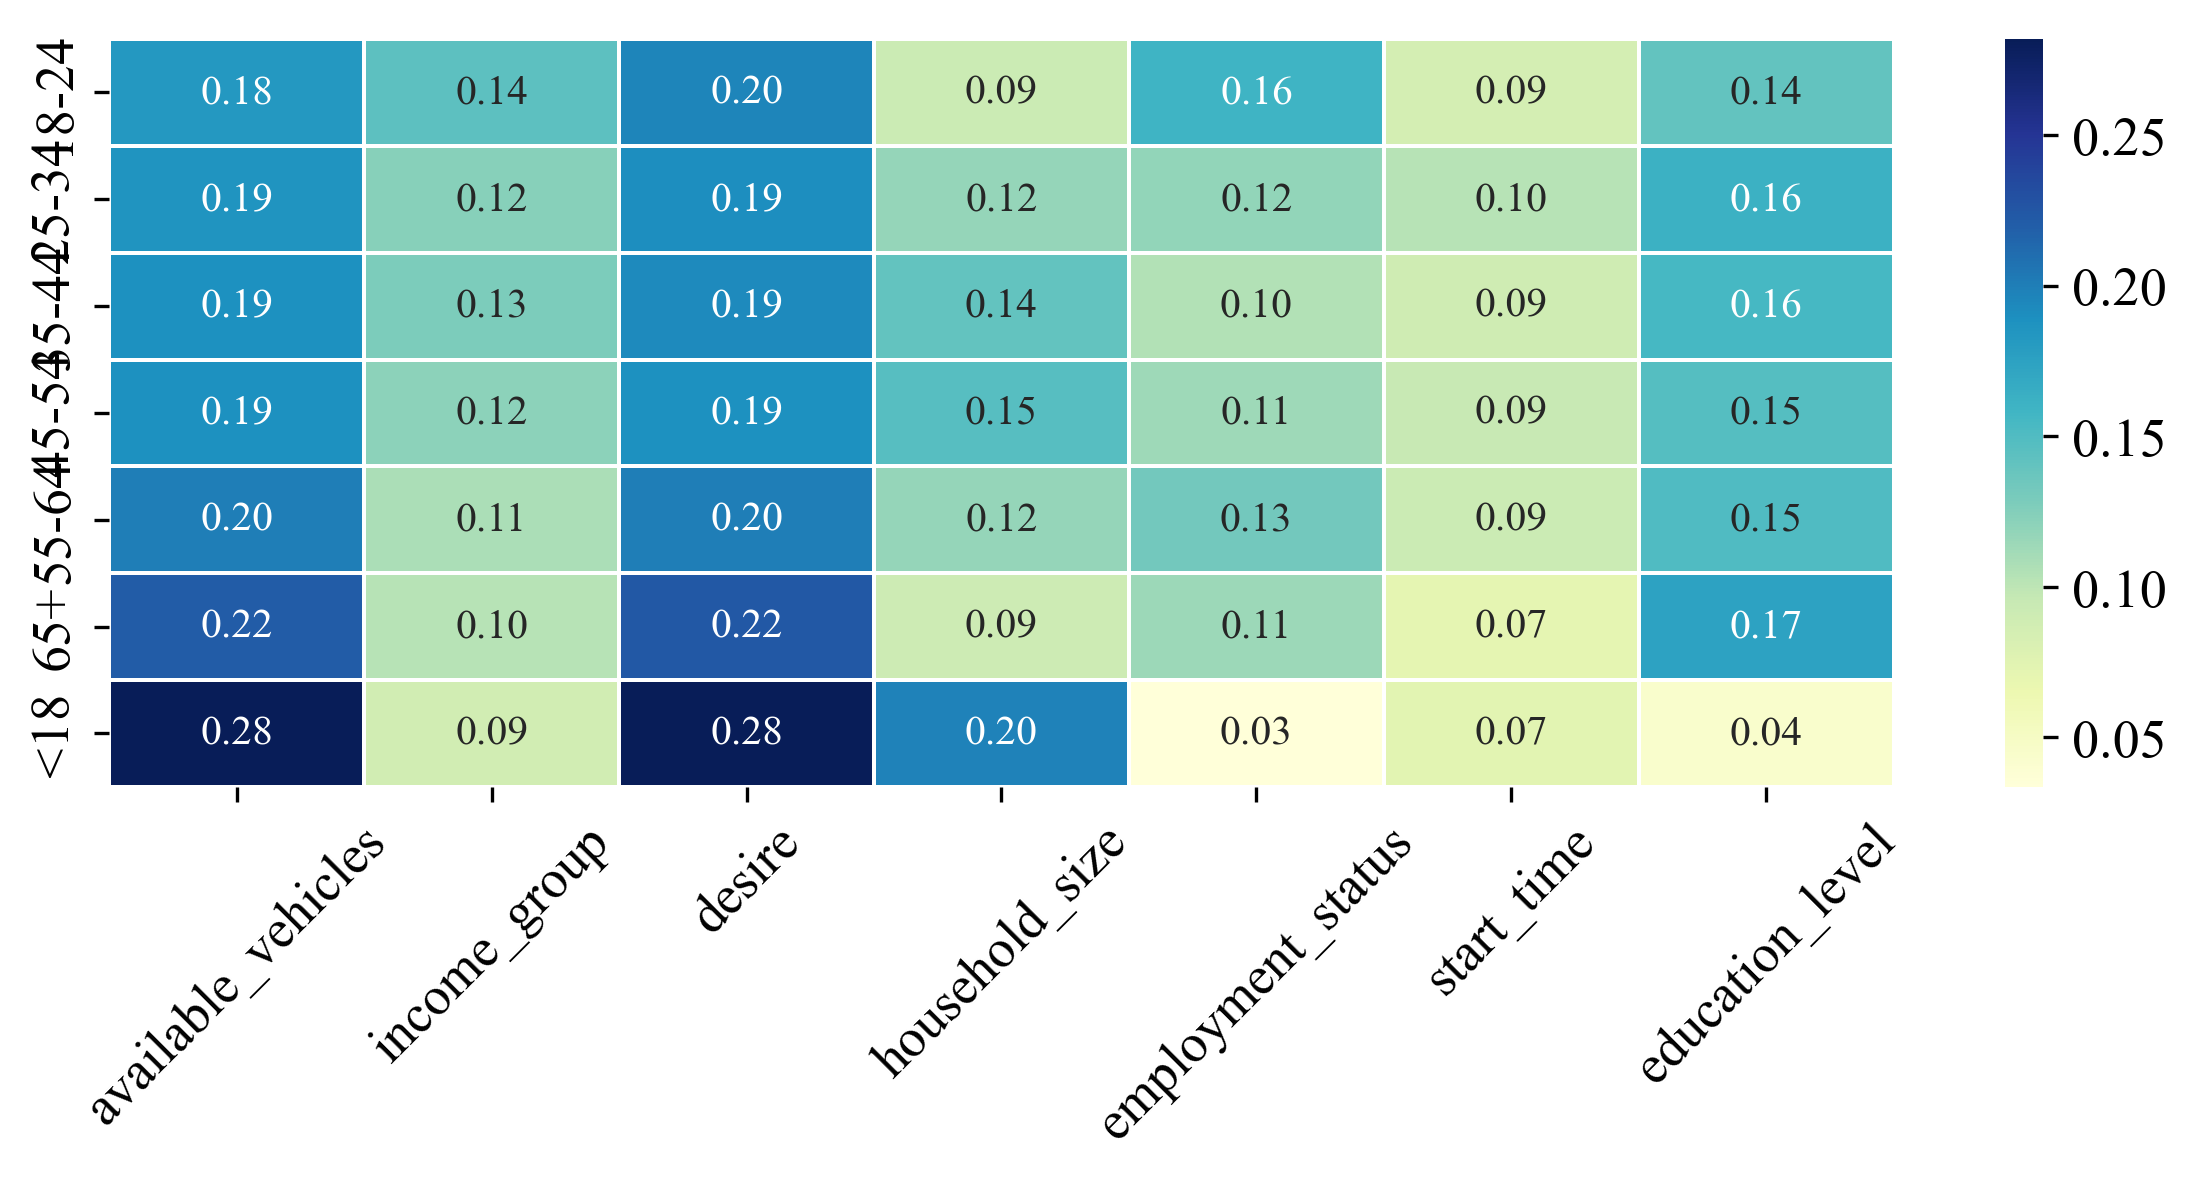

In [89]:
analysis_df = result_df.groupby('age_group').agg({'factors': lambda x: [item for sublist in x for item in sublist]}).reset_index()

input_factors = ['age_group', 'income_group', 'employment_status', 'household_size','available_vehicles', 'education_level', 'desire', 'start_time']

def factor_count(row):
    factor_counter = Counter(row)
    factor_counter = {k:v for k,v in factor_counter.items() if k in input_factors}
    return  factor_counter 
    
analysis_df['factors'] = analysis_df['factors'].apply(factor_count)
age_list = analysis_df['age_group'].tolist()
factor_list = analysis_df['factors'].tolist()

data_list = []
for age,item in zip(age_list,factor_list):
    item['age_group'] = age
    data_list.append(item)

df = pd.DataFrame(data_list)
df = df.set_index('age_group')
row_sums = df.sum(axis=1)
df_normalized = df.div(row_sums, axis=0)
df_normalized = df_normalized.rename(index={'Under 18': '<18'})
age_order = ['<18','18-24','25-34','35-44','45-54','55-64','65+']
df_normalized = df_normalized.reindex(age_order.reverse())

# 创建热力图
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 15,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})
plt.figure(figsize=(8, 4))
sns.heatmap(df_normalized, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

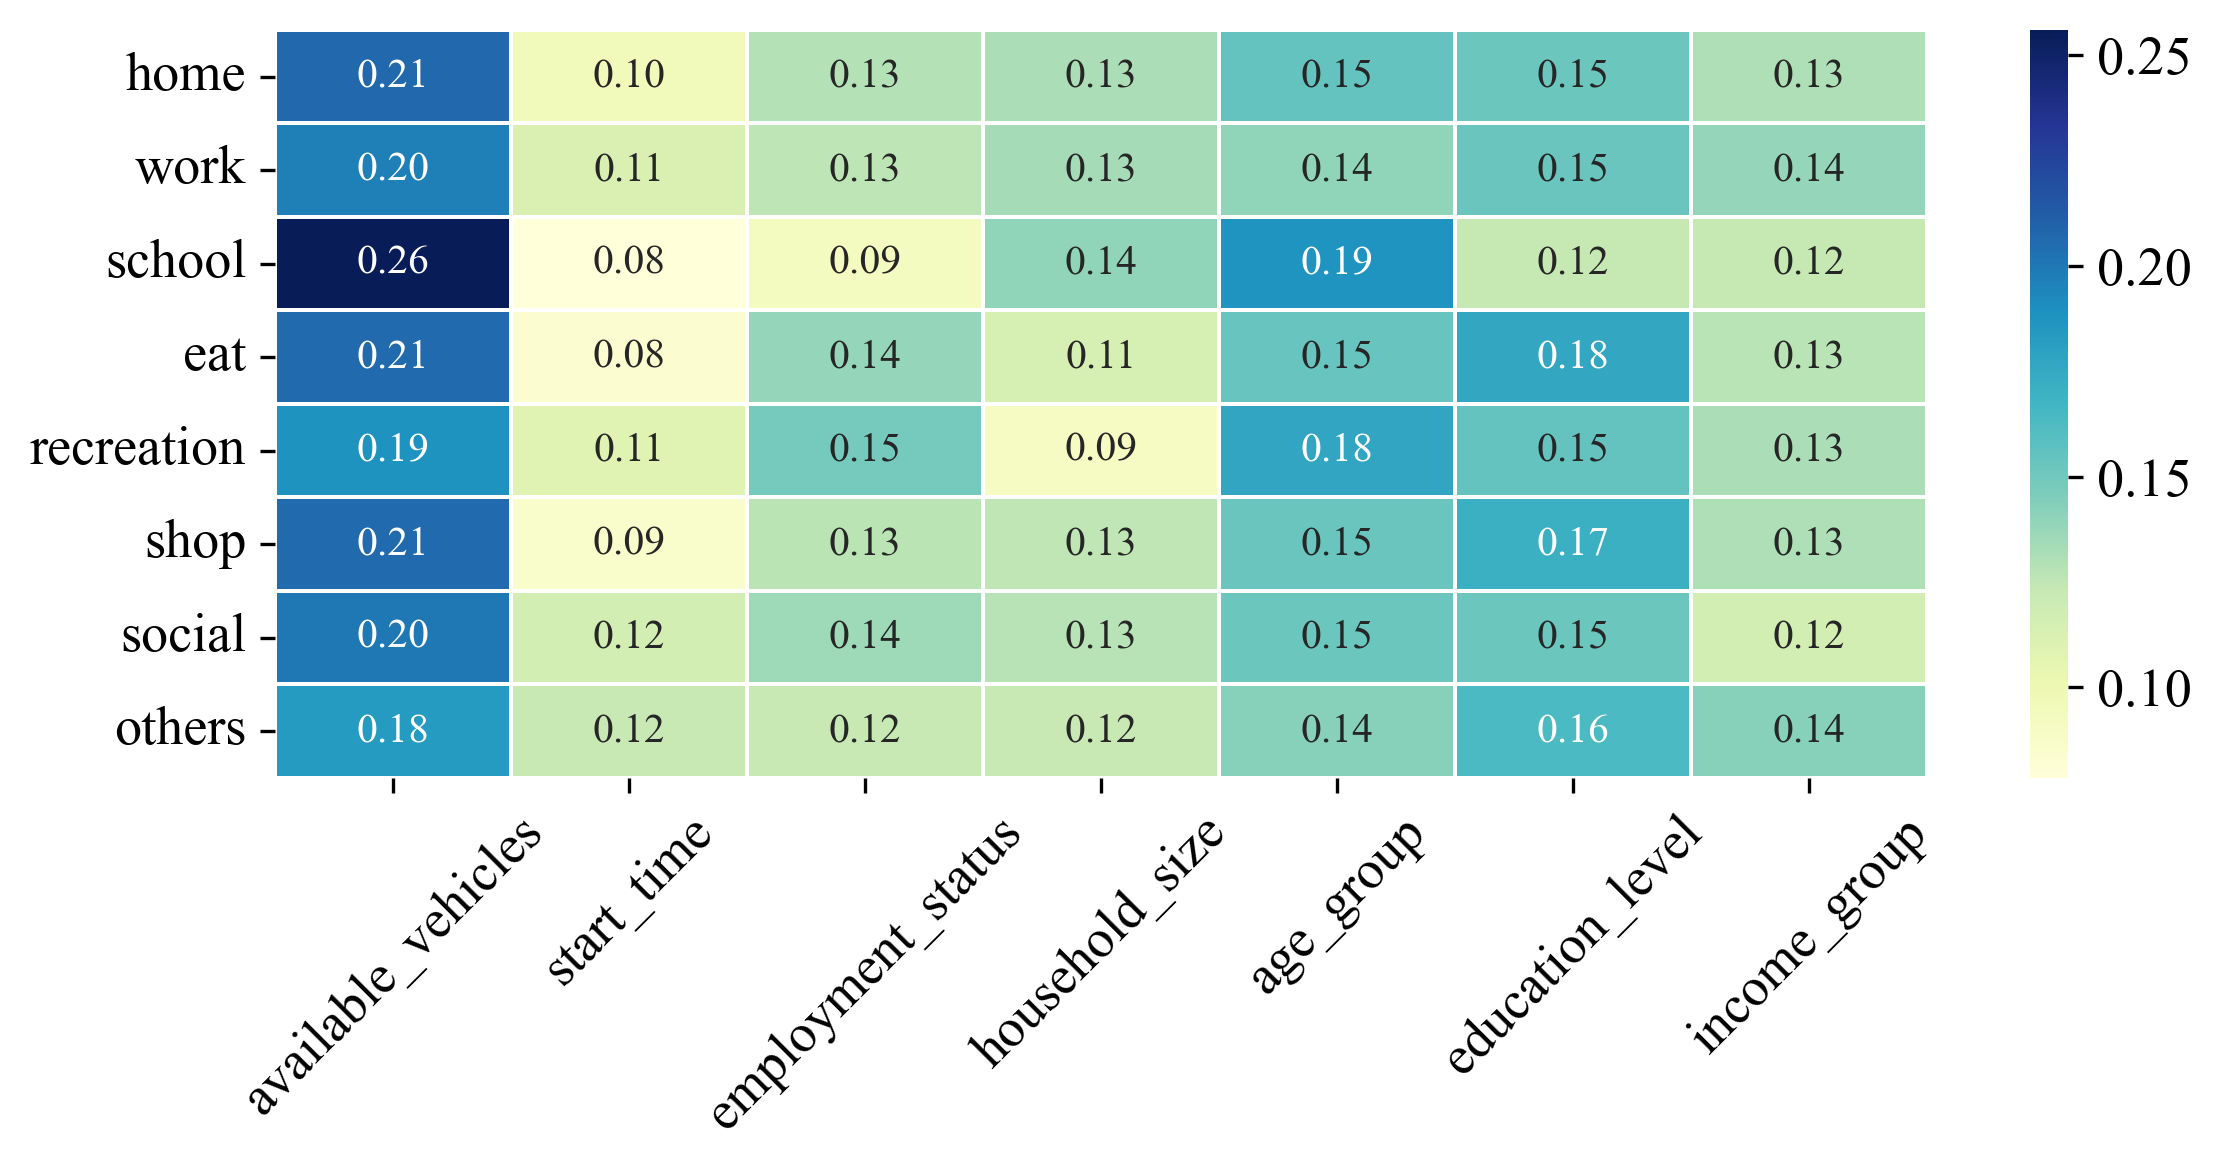

In [88]:
analysis_df = result_df.groupby('trip_purpose').agg({'factors': lambda x: [item for sublist in x for item in sublist]}).reset_index()

input_factors = ['age_group', 'income_group', 'employment_status', 'household_size','available_vehicles', 'education_level', 'start_time']

def factor_count(row):
    factor_counter = Counter(row)
    factor_counter = {k:v for k,v in factor_counter.items() if k in input_factors}
    return  factor_counter 
    
analysis_df['factors'] = analysis_df['factors'].apply(factor_count)
age_list = analysis_df['trip_purpose'].tolist()
factor_list = analysis_df['factors'].tolist()

data_list = []
for desire,item in zip(age_list,factor_list):
    item['desire'] = desire
    data_list.append(item)

df = pd.DataFrame(data_list)
df = df.set_index('desire')
row_sums = df.sum(axis=1)
df_normalized = df.div(row_sums, axis=0)
df_normalized = df_normalized.rename(index={'other_activity_type': 'others'})
desire_order = ['home','work','school','eat','recreation','shop','social','others']
# age_order = ['<18','18-24','25-34','35-44','45-54','55-64','65+']
df_normalized = df_normalized.reindex(desire_order)

# 创建热力图
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 15,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})
plt.figure(figsize=(8, 4))
sns.heatmap(df_normalized, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()